In [1]:
import tensorflow as tf
!pip install matplotlib
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [2]:
tf.test.is_built_with_cuda()

True

In [3]:
IMG_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Put here the relative path of your extracted dtaset",  #https://www.kaggle.com/datasets/arjuntejaswi/plant-village  -> this is the link of the dataset to be downloaded
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)


Found 20638 files belonging to 15 classes.


In [5]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [6]:
len(dataset)

645

In [7]:
for image_batch, label_batch in dataset.take(1):  
  print(image_batch.shape)
  print(label_batch.numpy())  
  print(image_batch[0])       
  print(image_batch[0].numpy) 
  print(image_batch[0].shape)


(32, 256, 256, 3)
[12 12  8 12  6  5  7  6 12  7 13  3  1  3  1  2  7  2 10  1 12  5 10  5
 12 14 12 12 10 12  5  6]
tf.Tensor(
[[[118. 100.  96.]
  [145. 127. 123.]
  [129. 111. 107.]
  ...
  [120. 107.  99.]
  [124. 111. 103.]
  [121. 108. 100.]]

 [[ 99.  81.  77.]
  [ 93.  75.  71.]
  [109.  91.  87.]
  ...
  [131. 118. 110.]
  [116. 103.  95.]
  [119. 106.  98.]]

 [[128. 110. 106.]
  [135. 117. 113.]
  [131. 113. 109.]
  ...
  [111.  98.  90.]
  [125. 112. 104.]
  [114. 101.  93.]]

 ...

 [[150. 142. 140.]
  [152. 144. 142.]
  [151. 143. 141.]
  ...
  [153. 145. 143.]
  [156. 148. 146.]
  [169. 161. 159.]]

 [[152. 144. 142.]
  [154. 146. 144.]
  [154. 146. 144.]
  ...
  [172. 164. 162.]
  [175. 167. 165.]
  [181. 173. 171.]]

 [[162. 154. 152.]
  [161. 153. 151.]
  [156. 148. 146.]
  ...
  [163. 155. 153.]
  [156. 148. 146.]
  [147. 139. 137.]]], shape=(256, 256, 3), dtype=float32)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
ar

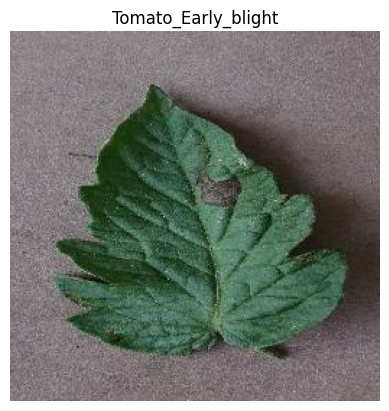

In [8]:
for image_batch, label_batch in dataset.take(1):
  plt.imshow(image_batch[0].numpy().astype("uint8"))
  plt.axis("off")    
  plt.title(class_names[label_batch[0]])    


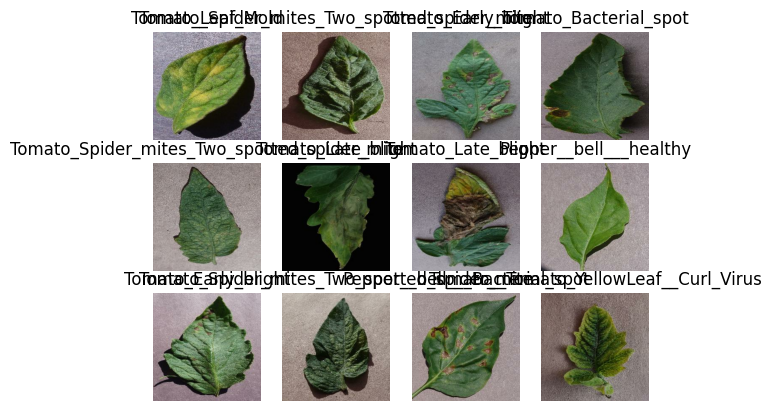

In [9]:
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1) 
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(class_names[label_batch[i]])


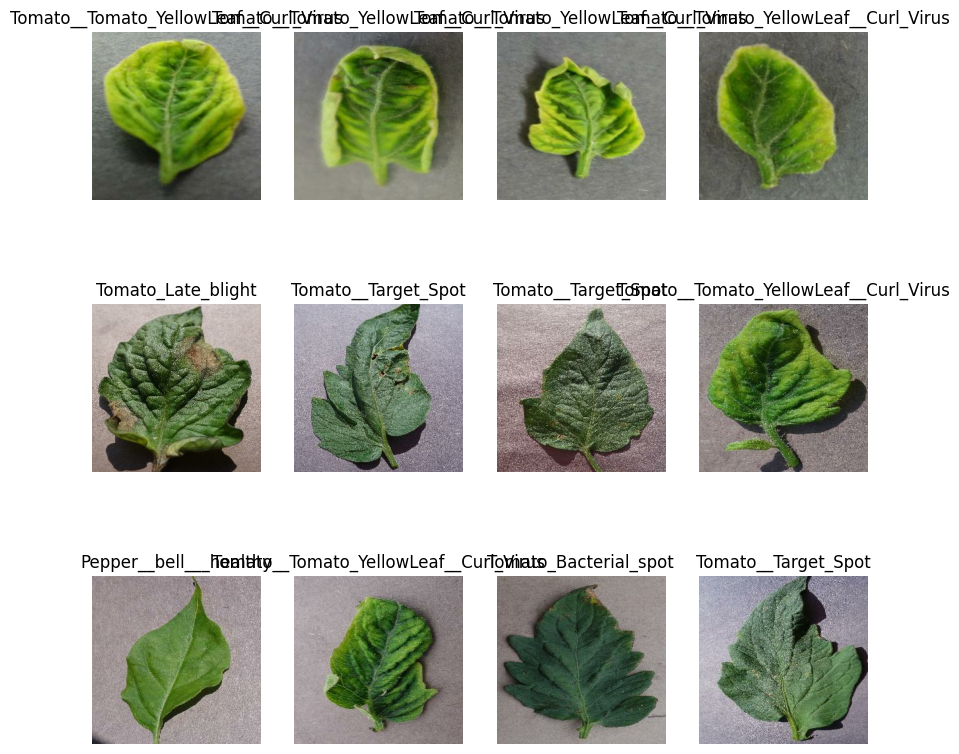

In [10]:
plt.figure(figsize=(10,10)) 
# display 12 images

for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1) 
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(class_names[label_batch[i]])


In [11]:
len(dataset)

645

In [12]:
train_size =0.8   
len(dataset)*train_size    

516.0

In [13]:
train_ds = dataset.take(516)
len(train_ds)              

516

In [14]:
test_ds = dataset.skip(516)     
len(test_ds)

129

In [15]:
val_size=0.1
len(dataset)*val_size

64.5

In [16]:
val_ds = test_ds.take(64)
len(val_ds)

64

In [17]:
test_ds = test_ds.skip(64)
len(test_ds)

65

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds





In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

516

In [21]:
len(val_ds)

64

In [22]:
len(test_ds)

65

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:

IMAGE_SIZE = 256

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])



In [25]:
# data augmentaion

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 15

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
516/516 [==============================] - 268s 434ms/step - loss: 1.8219 - accuracy: 0.4041 - val_loss: 1.1631 - val_accuracy: 0.6113
Epoch 2/50
516/516 [==============================] - 123s 238ms/step - loss: 0.9413 - accuracy: 0.6847 - val_loss: 0.6853 - val_accuracy: 0.7739
Epoch 3/50
516/516 [==============================] - 128s 249ms/step - loss: 0.5804 - accuracy: 0.8011 - val_loss: 0.6066 - val_accuracy: 0.7910
Epoch 4/50
516/516 [==============================] - 128s 248ms/step - loss: 0.4346 - accuracy: 0.8507 - val_loss: 0.3244 - val_accuracy: 0.8940
Epoch 5/50
516/516 [==============================] - 116s 226ms/step - loss: 0.3482 - accuracy: 0.8770 - val_loss: 0.4326 - val_accuracy: 0.8569
Epoch 6/50
516/516 [==============================] - 121s 235ms/step - loss: 0.2800 - accuracy: 0.9030 - val_loss: 0.2934 - val_accuracy: 0.8975
Epoch 7/50
516/516 [==============================] - 117s 227ms/step - loss: 0.2431 - accuracy: 0.9147 - val_loss: 0.2124 -

In [37]:
model.save("model.h5")

In [38]:
scores = model.evaluate(test_ds)

65/65 [==============================] - 96s 109ms/step - loss: 0.0707 - accuracy: 0.9851


In [39]:
scores

[0.07068508118391037, 0.9850961565971375]

In [40]:
history

In [41]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 516}

In [42]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [43]:
history.history["accuracy"]

[0.40413033962249756,
 0.684714138507843,
 0.8011143207550049,
 0.8506540656089783,
 0.8769985437393188,
 0.9029796719551086,
 0.9147287011146545,
 0.9245397448539734,
 0.9363493323326111,
 0.9398618936538696,
 0.9450702667236328,
 0.9571826457977295,
 0.960392415523529,
 0.9591206312179565,
 0.9640867114067078,
 0.9623909592628479,
 0.9756540656089783,
 0.9708696603775024,
 0.9766230583190918,
 0.9724442958831787,
 0.9699006676673889,
 0.9811046719551086,
 0.9777737259864807,
 0.9755329489707947,
 0.9780765771865845,
 0.978500485420227,
 0.9862524271011353,
 0.976259708404541,
 0.9774709343910217,
 0.9891594052314758,
 0.9773498177528381,
 0.983829915523529,
 0.9783793687820435,
 0.9883115291595459,
 0.9795905947685242,
 0.9870397448539734,
 0.9858284592628479,
 0.9810441136360168,
 0.9881904125213623,
 0.9841327667236328,
 0.9851623177528381,
 0.9858284592628479,
 0.984677791595459,
 0.9847383499145508,
 0.9882509708404541,
 0.9844355583190918,
 0.9883115291595459,
 0.992974817752838

In [44]:
# plot the history stuff in matplotlib chart
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


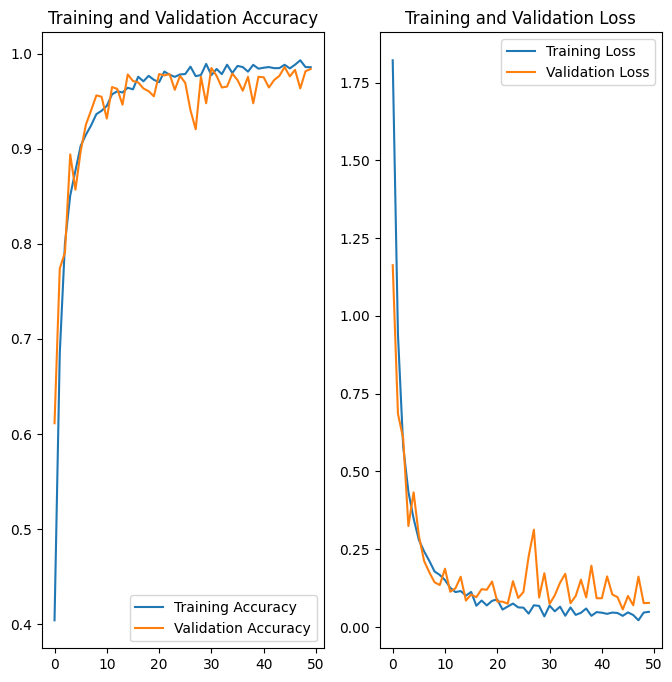

In [45]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



first image to predict
actual label: Tomato_healthy
1/1 [==============================] - 1s 1s/step
predicted label: Tomato_healthy


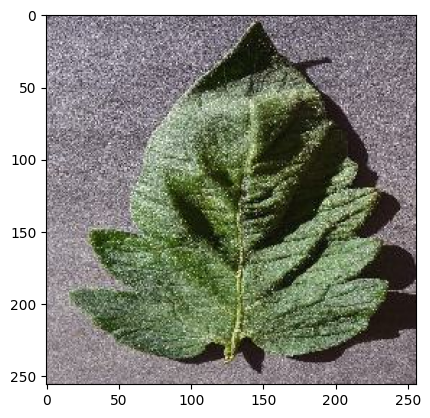

In [46]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [47]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 54ms/step


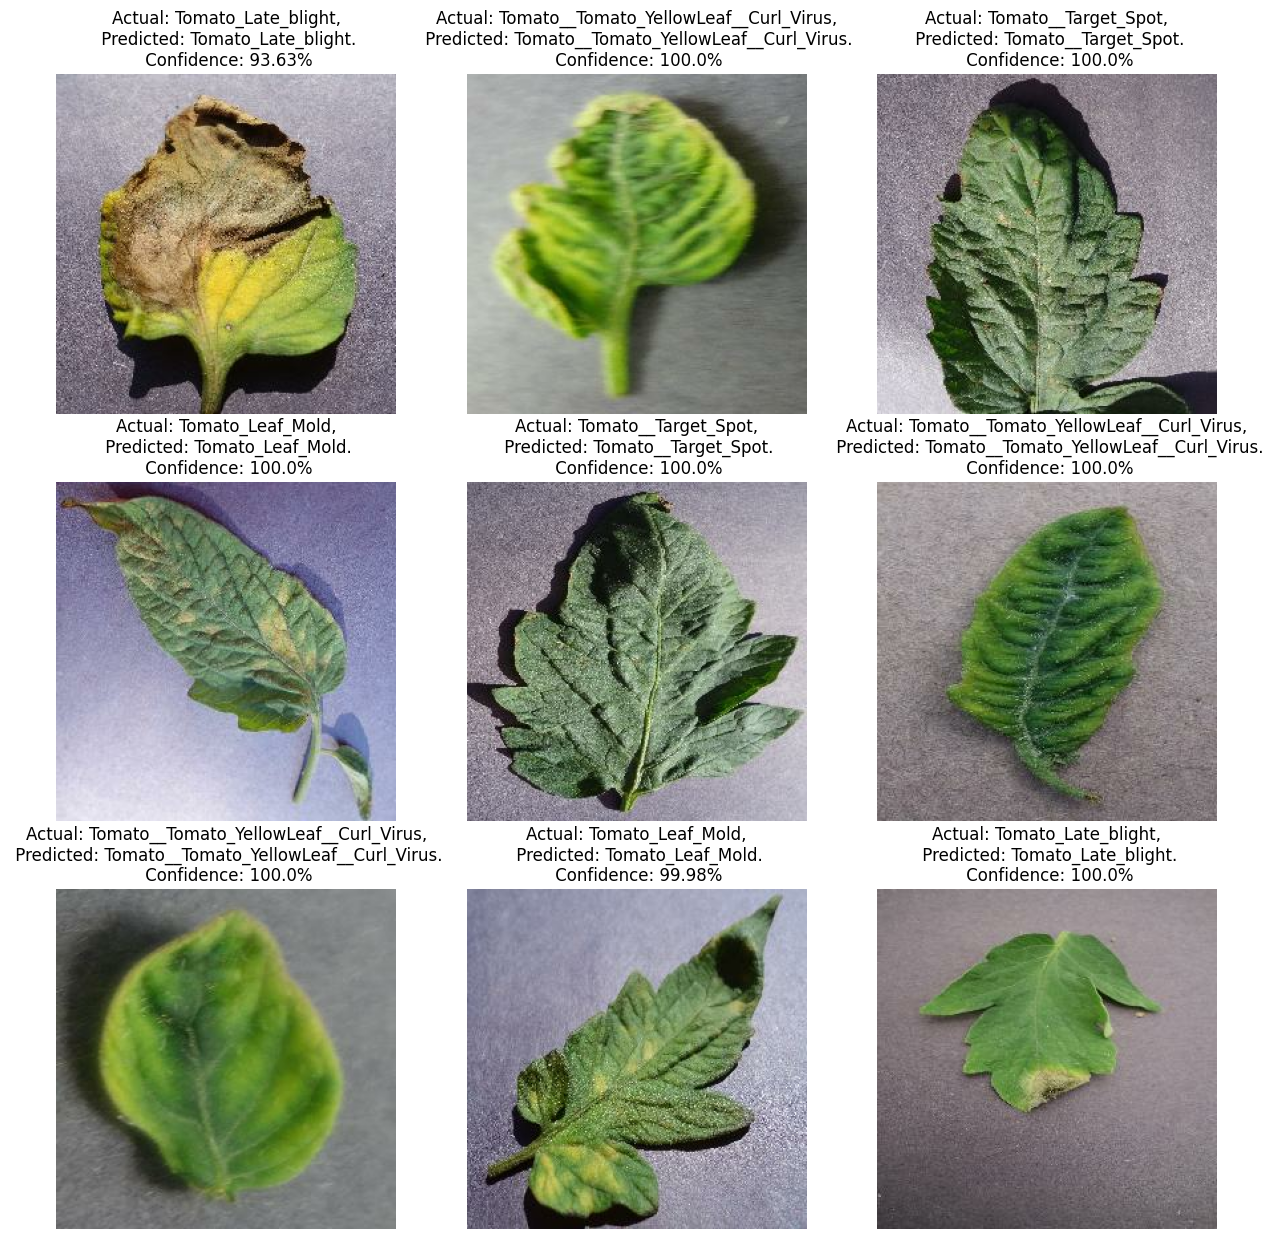

In [48]:
# running inference for a few samples

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")